In [1]:
import matplotlib.pyplot as plt
from pyNA.pyna import pyna
import openmdao.api as om
import numpy as np

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/Users/laurensvoet/miniconda3/lib/python3.10/site-packages/pyoptsparse/pyOpt_MPI.py:68: UserWarning: mpi4py could not be imported. mpi4py is required to use the parallel gradient analysis and parallel objective analysis for non-gradient based optimizers. Continuing using a dummy MPI module from pyOptSparse.
  warnings.warn(warn)
/var/folders/6w/2tdqp9m179gg5blnzww9hgjc0000gn/T/ipykernel_87454/3696665389.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


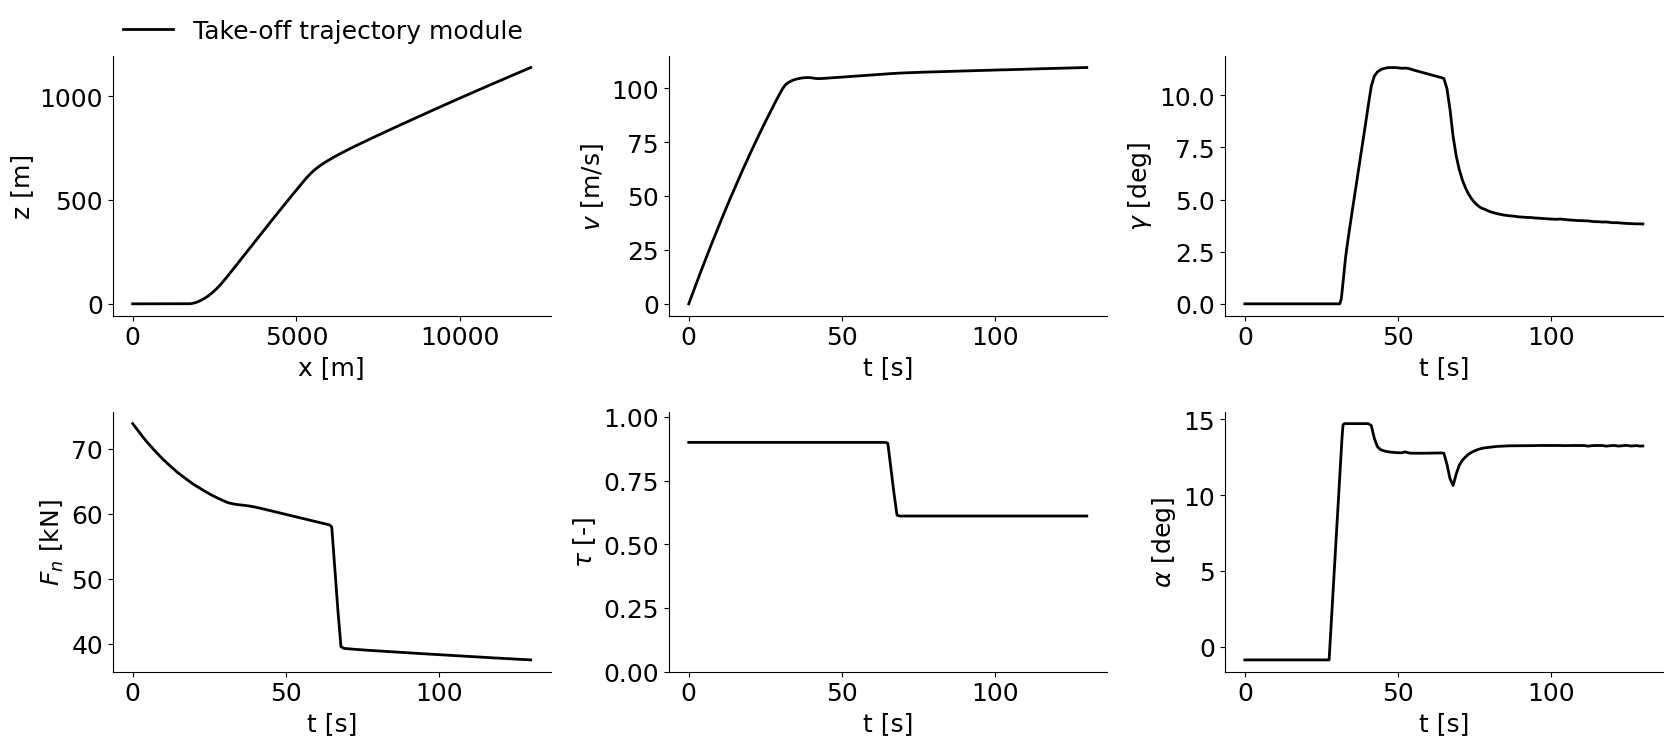

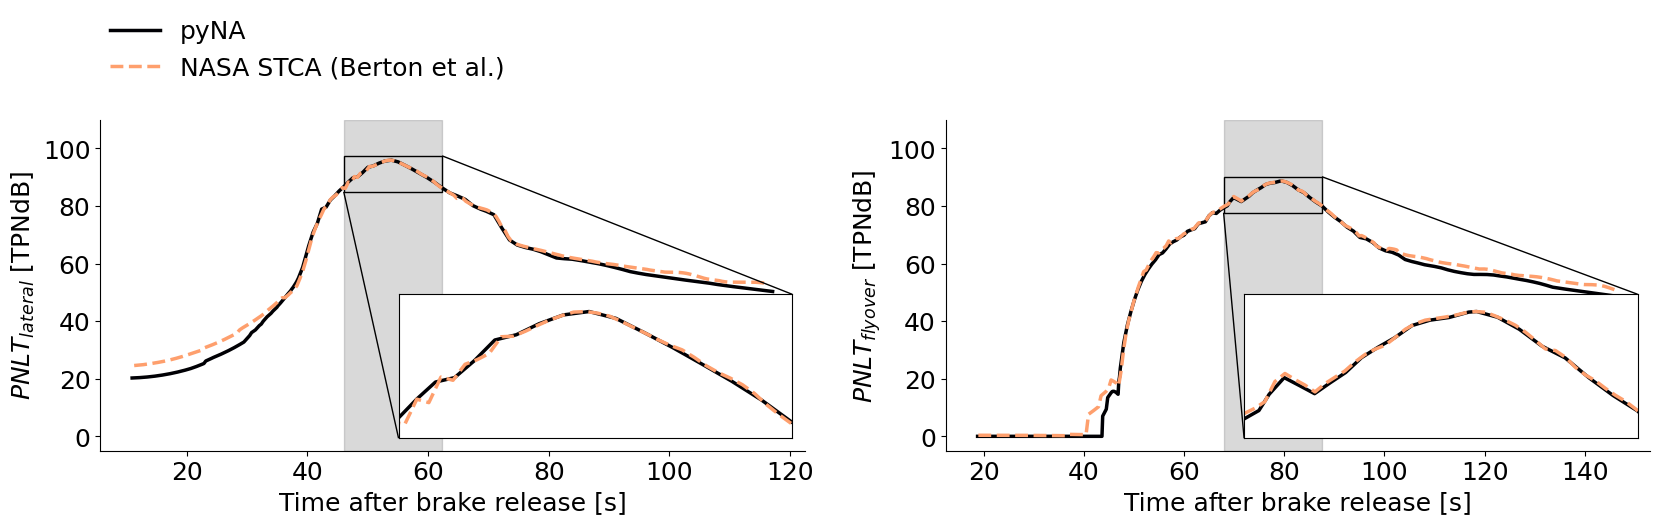

In [3]:
# Get NASA STCA trajectory from file
py_stca = pyna(all_sources=True, 
               trajectory_mode='time_history')

py_stca.trajectory.load_data_from_file()
py_stca.trajectory.connect()
py_stca.noise.connect()
py_stca.calculate_time_history()

# # Post-processing
py_stca.plot_trajectory()

from pyNA.src.stca_data import StcaData
stca_data = StcaData()
stca_data.load_levels_time_history(settings=py_stca.settings)
py_stca.plot_noise_timeseries(level_compare=stca_data, label_compare='NASA STCA (Berton et al.)')

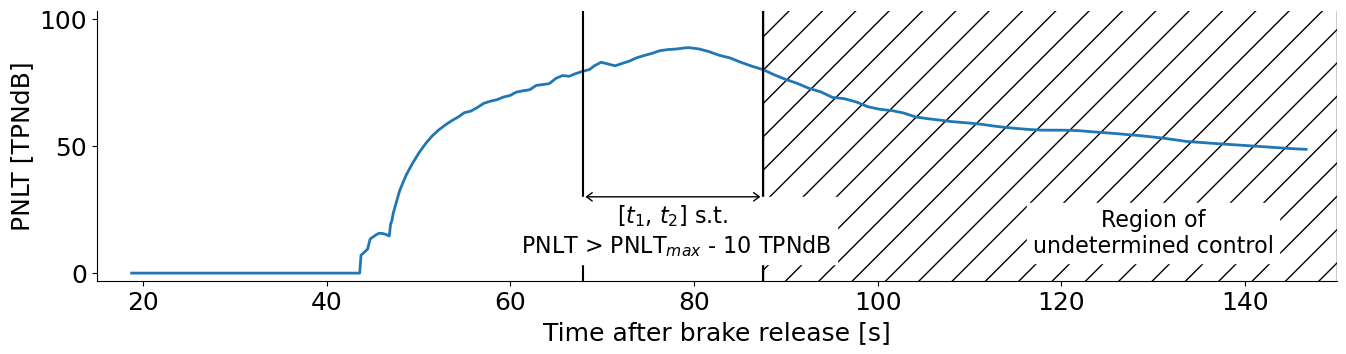

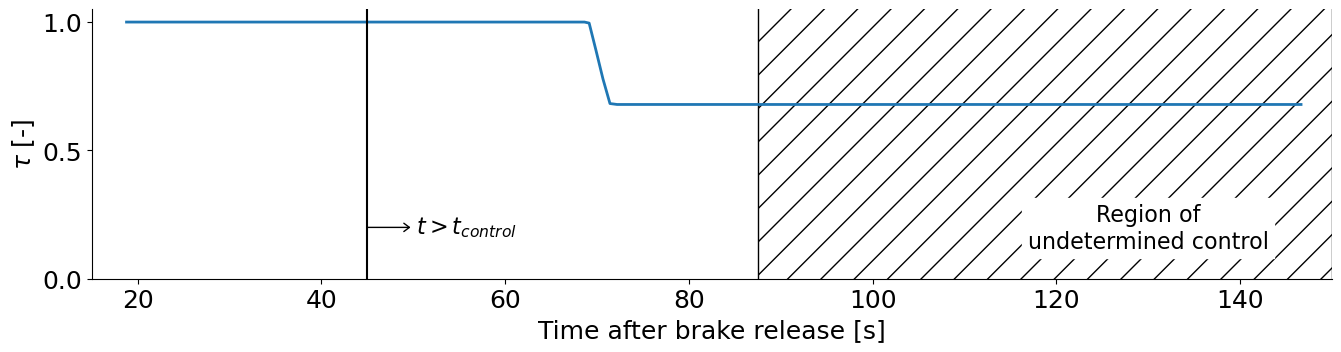

In [6]:
# Figure 1: domain of dependence EPNNL
fig, ax = plt.subplots(1,1, figsize=(16,3.5))
plt.plot(py_stca.problem.get_val('noise.t_o')[1,:], py_stca.problem.get_val('noise.pnlt')[1,:])

t_epnl = py_stca.problem.get_val('noise.t_o')[1,:][np.where(py_stca.problem.get_val('noise.pnlt')[1,:] > np.max(py_stca.problem.get_val('noise.pnlt')[1,:])-10)]

plt.plot([t_epnl[0], t_epnl[0]], [-5, 105], 'k', linewidth=1.5)
plt.plot([t_epnl[-1], t_epnl[-1]], [-5, 105], 'k', linewidth=1.5)
ax.fill_between([t_epnl[-1], 150], [-5, -5], [105, 105], hatch='/', facecolor="none", edgecolor='k')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([15, 150])
ax.set_ylim([-3, 103])
ax.set_yticks([0, 50, 100])
ax.set_xlabel('Time after brake release [s]')
ax.set_ylabel('PNLT [TPNdB]')

t = ax.annotate(xy=((t_epnl[0]+t_epnl[-1])/2, 8), text='[$t_1$, $t_2$] s.t.\n PNLT > PNLT$_{max}$ - 10 TPNdB', fontsize=16, ha='center')
t.set_bbox(dict(facecolor='white', edgecolor='white'))

ax.annotate("", xy=(t_epnl[0], 30), xytext=(t_epnl[-1], 30), arrowprops=dict(arrowstyle="<->, head_width=0.3"))

t = ax.annotate(xy=(130, 8), text='Region of\nundetermined control', ha='center', fontsize=16)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

# Figure 2: domain of influence control 
fig, ax = plt.subplots(1,1, figsize=(16,3.5))
plt.plot(py_stca.problem.get_val('noise.t_o')[1,:], py_stca.problem.get_val('trajectory.tau')/py_stca.problem.get_val('trajectory.tau')[0])
ax.fill_between([t_epnl[-1], 150], [-5, -5], [105, 105], hatch='/', facecolor="none", edgecolor='k')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([15, 150])
ax.set_ylim([0, 1.05])
ax.set_yticks([0, 0.5, 1.0])
ax.set_xlabel('Time after brake release [s]')
ax.set_ylabel(r'$\tau$ [-]')
ax.plot([45, 45], [0, 1.05], 'k', linewidth=1.5)

ax.annotate("", xy=(44.7, 0.2), xytext=(50, 0.2), arrowprops=dict(arrowstyle="<-, head_width=0.3"))
t = ax.annotate(xy=(50.3, 0.175), text='$t>t_{control}$', ha='left', fontsize=16)

t = ax.annotate(xy=(130, 0.12), text='Region of\nundetermined control', ha='center', fontsize=16)
t.set_bbox(dict(facecolor='white', edgecolor='white'))

In [8]:
# Compute NASA STCA trajectory using take-off model
z_cb = py_stca.problem.get_val('z')[np.where(py_stca.problem.get_val('tau') < 0.65)[0][0]]
v_max = py_stca.problem.get_val('v')[-1]
x_max = py_stca.problem.get_val('x')[-1]

# Set up pyNA
py = pyna(case_name='stca',
          engine_name='engine_derivative',
          trajectory_mode='model',
          z_cb=z_cb,
          v_max=v_max,
          x_max=x_max,
          pkrot=True,
          shielding=False)

# Initialize trajectory model
from pyNA.src.trajectory_model.sst.sst_take_off_trajectory import SSTTakeOffTrajectory

# Trajectory controls
controls = dict()
controls['k_rot'] = 1.2
controls['tau'] = {'groundroll':0.88, 'rotation':0.88, 'liftoff':0.88, 'vnrs':0.88, 'cutback':0.61}
controls['theta_flaps'] = {'groundroll':10., 'rotation':10., 'liftoff':10., 'vnrs':10., 'cutback':10.}
controls['theta_slats'] = {'groundroll':-6., 'rotation':-6., 'liftoff':-6., 'vnrs':-6., 'cutback':-6.}

model = SSTTakeOffTrajectory(settings=py.settings, aircraft=py.aircraft, controls=controls, mode='cutback', objective='t_end')
py.trajectory.connect(model=model)
py.calculate_trajectory(objective='time')


--- Constraint Report [phases] ---
    --- groundroll ---
        [final]   0.0000e+00 == flight_dynamics.v_rot_residual [m/s]
    --- rotation ---
        [final]   1.1000e+00 == flight_dynamics.n [None]
    --- liftoff ---
        [path]    0.0000e+00 <= flight_dynamics.gamma_dot  [deg/s]
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]
    --- vnrs ---
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]
        [path]    0.0000e+00 <= gamma  [deg]
    --- cutback ---
        [path]    0.0000e+00 <= flight_dynamics.v_dot  [m/s**2]

Model viewer data has already been recorded for Driver.
Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 5.984556 seconds.
Total jacobian shape: (247, 169) 


Jacobian shape: (247, 169)  ( 3.91% nonzero)
FWD solves: 11   REV solves: 0
Total colors vs. total size: 11 vs 169  (93.5% improvement)

Sparsity computed using tolerance: 1e-12
Time to compute sparsity: 5.984556 sec.

Converged: True


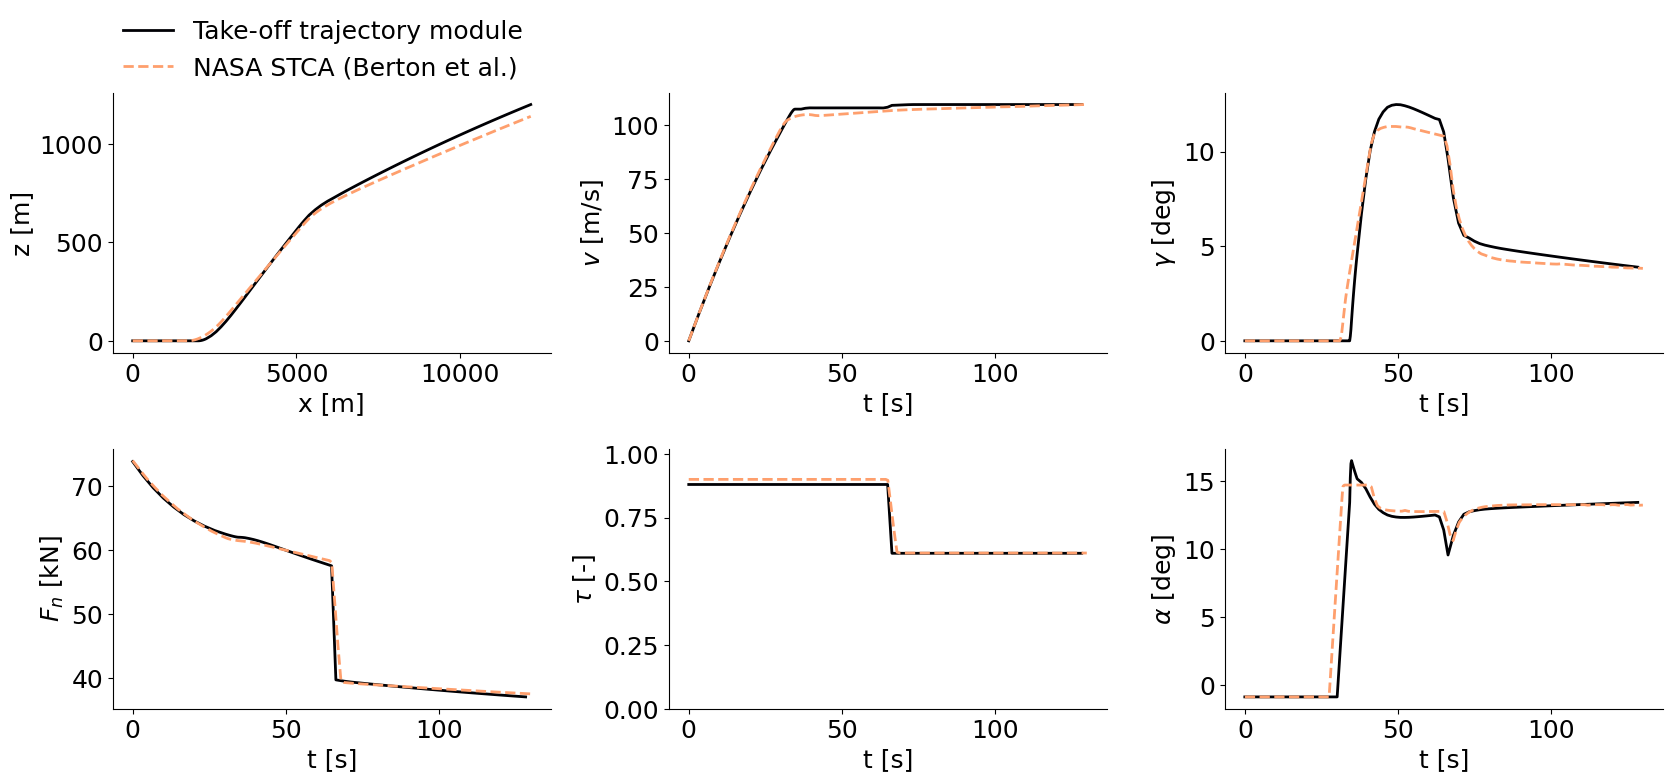

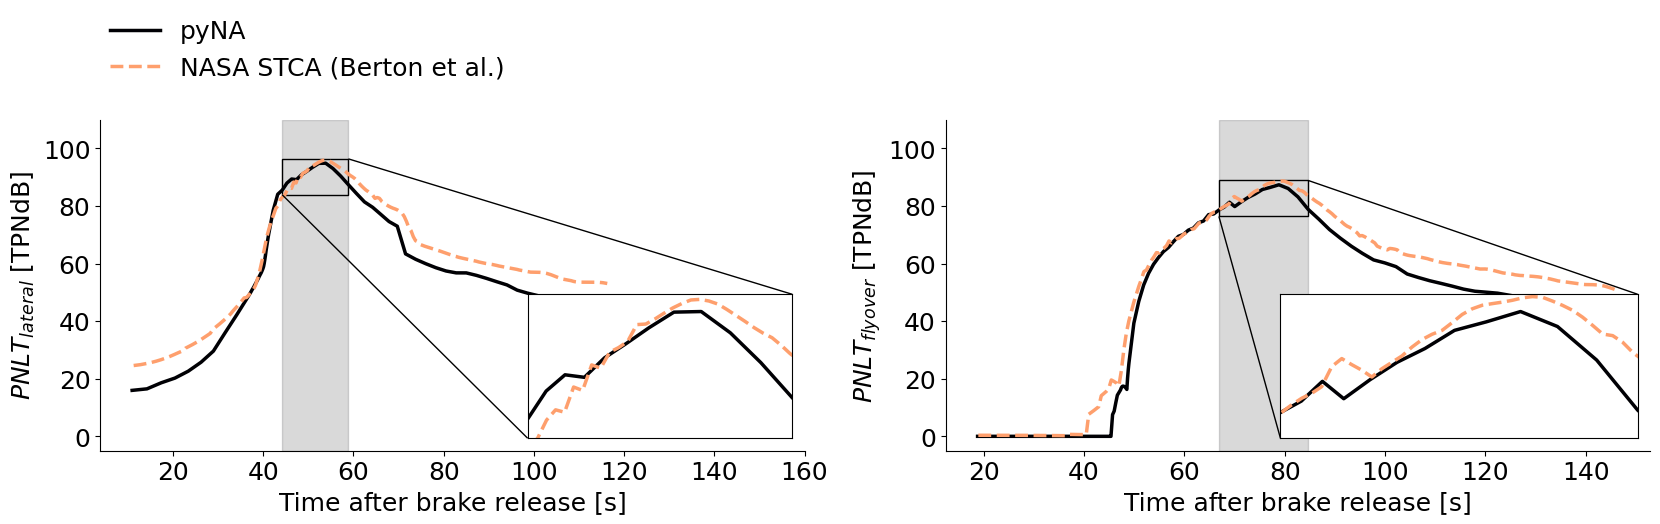

In [9]:
# Get NASA STCA trajectory from file
py3 = pyna(all_sources=True, 
           trajectory_mode='time_history')

py3.trajectory.load_data_from_problem(py.problem)
py3.trajectory.connect()
py3.noise.connect()
py3.calculate_time_history()

# Post-processing
from pyNA.src.stca_data import StcaData

py3.plot_trajectory(path_compare=py_stca.problem, label_compare='NASA STCA (Berton et al.)')

stca_data = StcaData()
stca_data.load_levels_time_history(settings=py3.settings)

py3.plot_noise_timeseries(level_compare=stca_data, label_compare='NASA STCA (Berton et al.)')